We're attempting to build a regression model that would allow is to predit property crime rates.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from scipy import stats
from scipy.stats import ttest_ind
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import pandas as pd

In [2]:
df = pd.read_csv("law.csv")

In [3]:
#drop column that contains no data
df = df.drop('Rape\n(revised\ndefinition)1', axis=1)

In [4]:
#simplify column names
df.columns = ['city', 'population', 'violent crime', 'murder', 'rape', 'robbery', 'assault', 
              'property crime','burglary', 'larceny/theft', 'motor vehicle theft', 'arson']

In [5]:
#remove all commas
df = df.replace({',': ''}, regex=True)

#convert all continuous data into floats
df[['population', 'violent crime', 'murder', 'rape', 'robbery', 'assault', 
              'property crime','burglary', 'larceny/theft', 'motor vehicle theft', 'arson']] = df[['population', 'violent crime', 'murder', 'rape', 'robbery', 'assault', 
              'property crime','burglary', 'larceny/theft', 'motor vehicle theft', 'arson']].astype(float)

In [6]:
df.head()

,city,population,violent crime,murder,rape,robbery,assault,property crime,burglary,larceny/theft,motor vehicle theft,arson
0,Adams Village,1861.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,1.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


Let's check if there appears to be an outliers and then remove them.

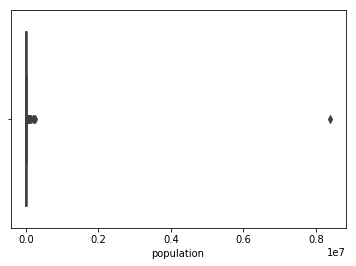

In [7]:
#check for outliers
sns.boxplot(df['population'])
plt.show()

In [8]:
#remove outliers (based off of 3 standard deviations)
df[np.abs(df.population-df.population.mean())<=(3*df.population.std())] 
df = df[~(np.abs(df.population-df.population.mean())>(3*df.population.std()))]

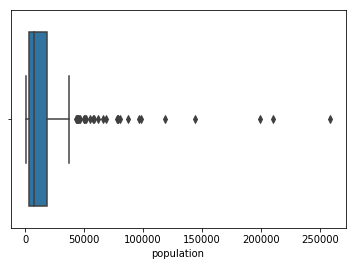

In [9]:
#new boxplot
sns.boxplot(df['population'])
plt.show()

In [10]:
features = df[['city', 'property crime', 'population']]

In [11]:
#disable warning
pd.options.mode.chained_assignment = None

#create population squared column
features['population_squared'] = np.square(df['population'])

In [12]:
#convert murder and robbery (continuous data) columns into categorical data
features['murder'] = np.where(df['murder']>0, 1, 0)
features['robbery'] = np.where(df['robbery']>0, 1, 0)

In [13]:
features.head()

,city,property crime,population,population_squared,murder,robbery
0,Adams Village,12.0,1861.0,3.463321e+06,0,0
1,Addison Town and Village,24.0,2577.0,6.640929e+06,0,0
2,Akron Village,16.0,2846.0,8.099716e+06,0,0
3,Albany,1.0,97956.0,9.595378e+09,1,1
4,Albion Village,223.0,6388.0,4.080654e+07,0,1


Let's check and see if any of the data is normally distributed, allowing us to make a regression model.

In [14]:
df2 = df[['city', 'population', 'violent crime', 'murder', 'rape', 'robbery', 'assault', 
              'property crime','burglary', 'larceny/theft', 'motor vehicle theft', 'arson']]

C:\Users\starr\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


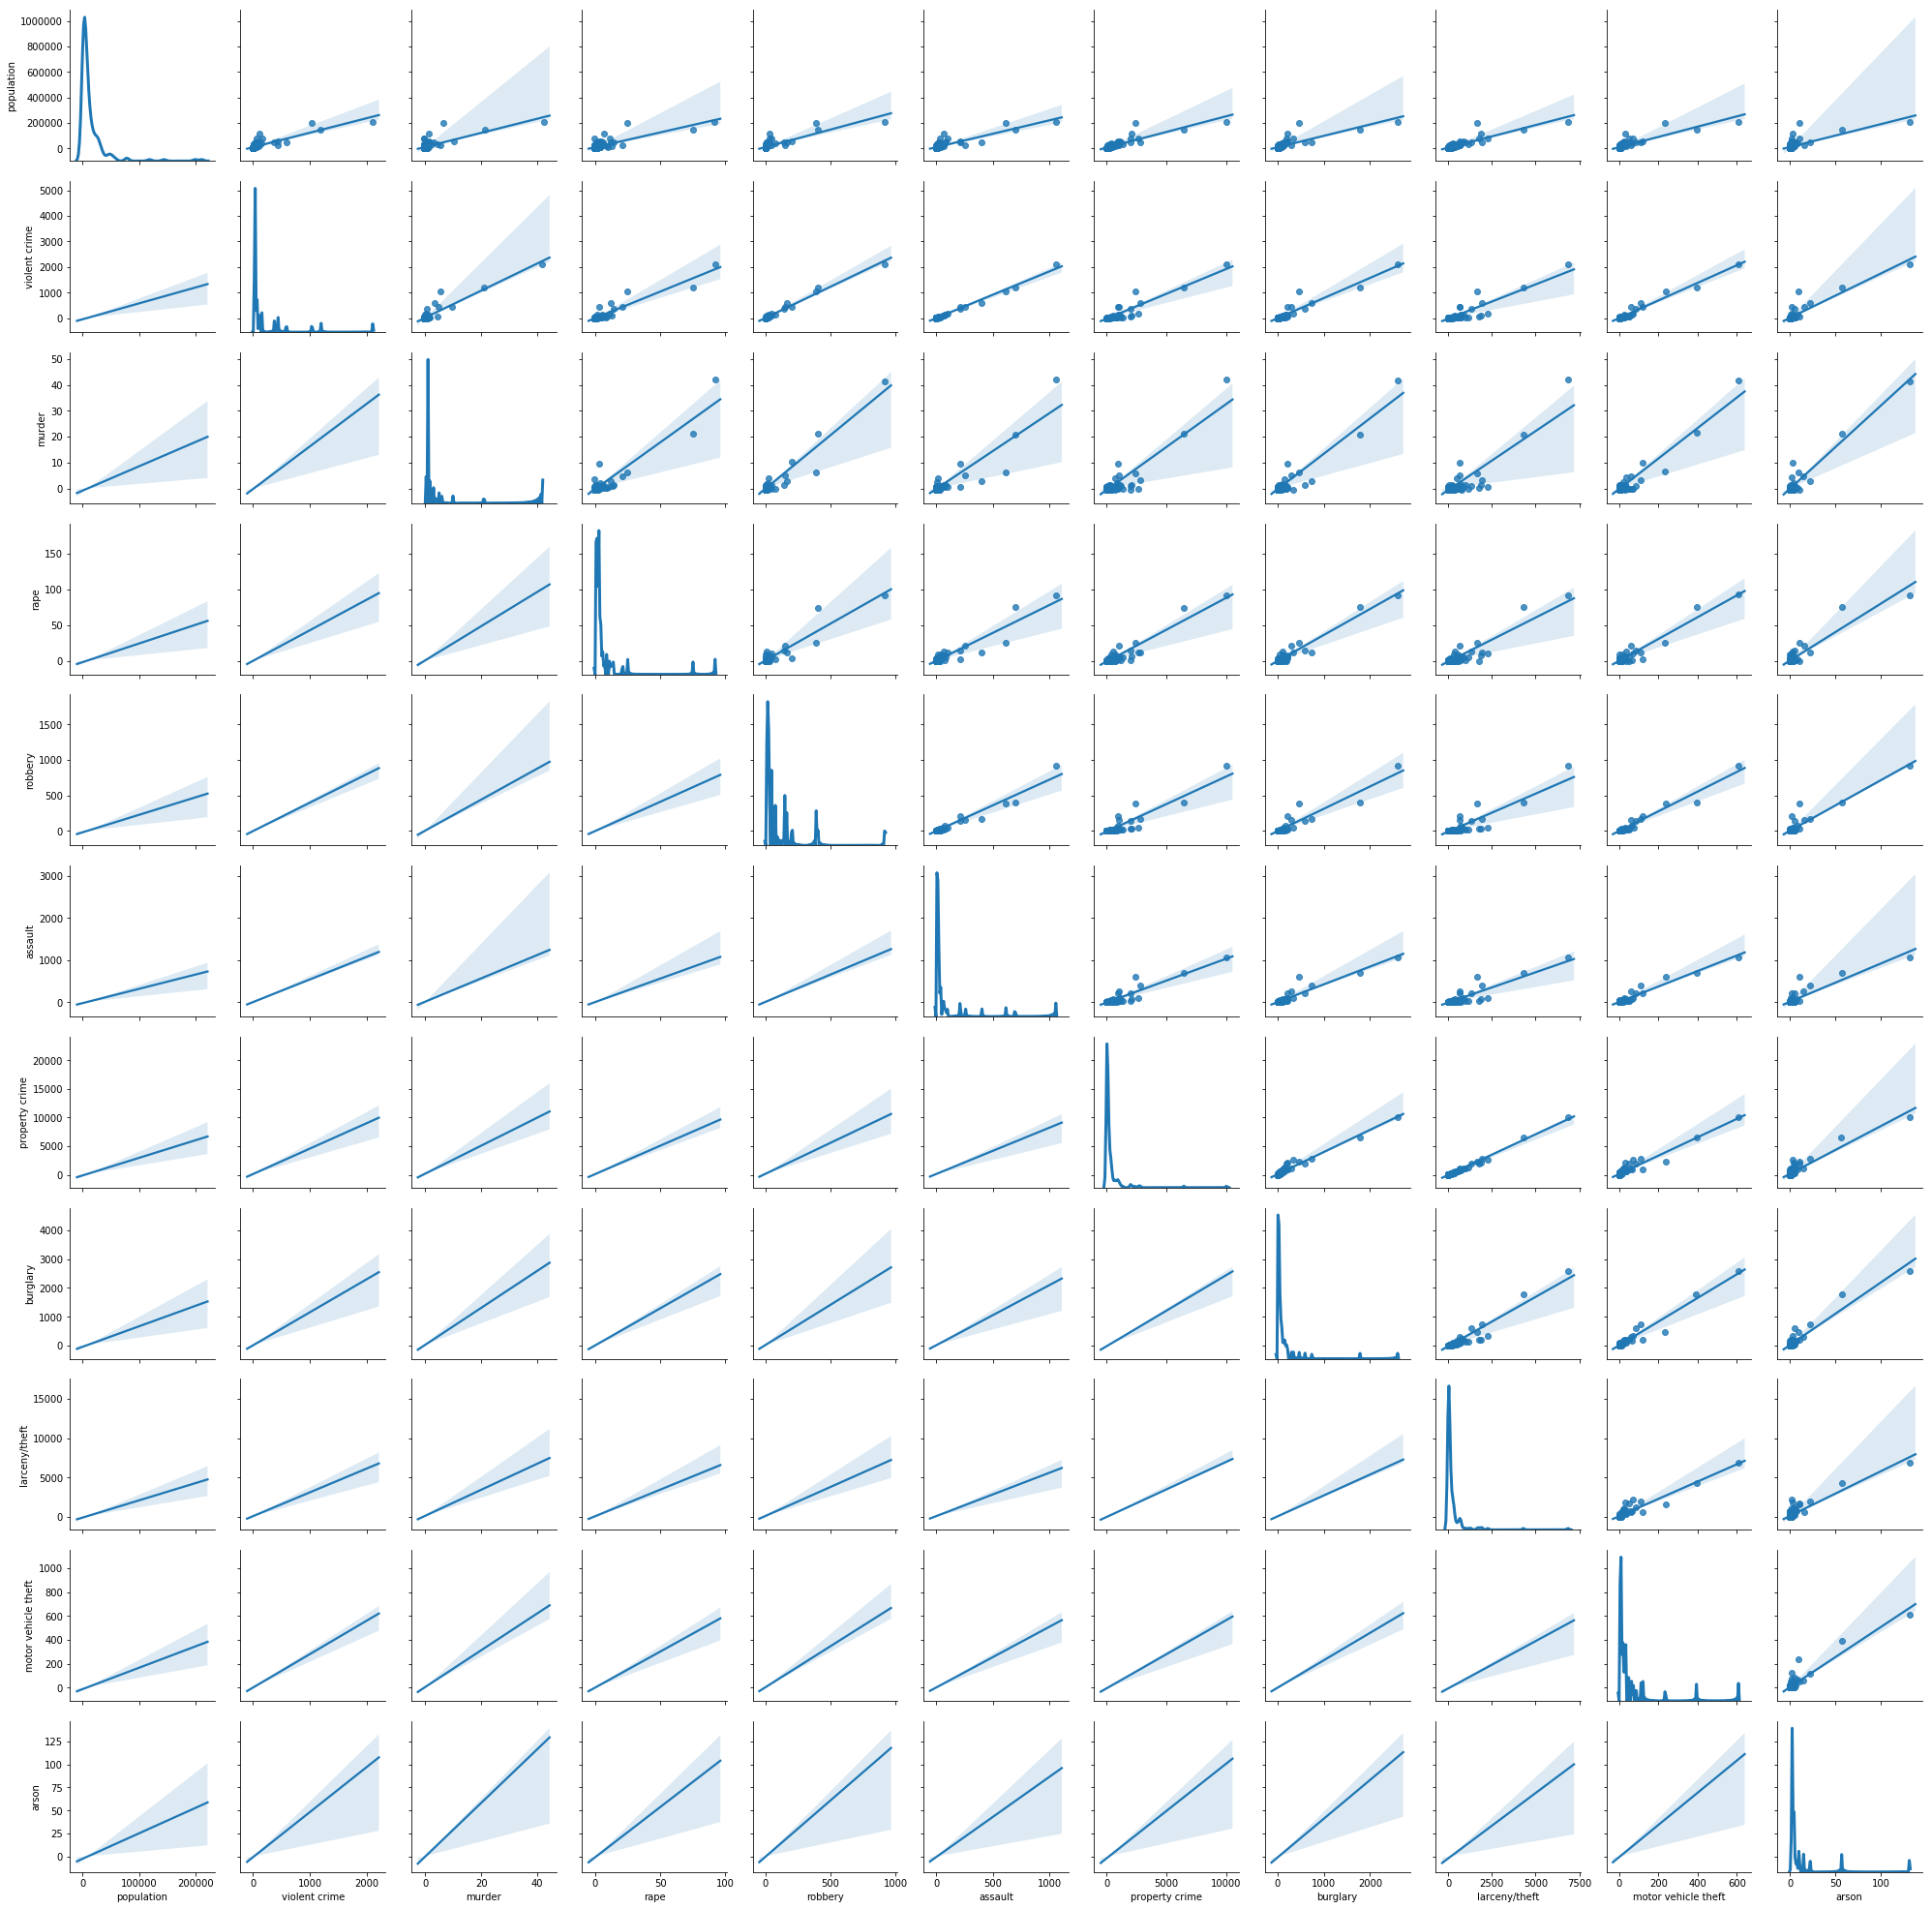

In [15]:
#make a pair grid to see if any of the values are normally distributed
g = sns.PairGrid(df2.dropna(), diag_sharey=False)

g.map_upper(sns.regplot, x_jitter=.5, y_jitter=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)

plt.show()

None of the data appears to be normally distributed, making it unusable for regression. Perhaps we will have more luck if we check the log, square root, or inverse of a column. Let's start with population.

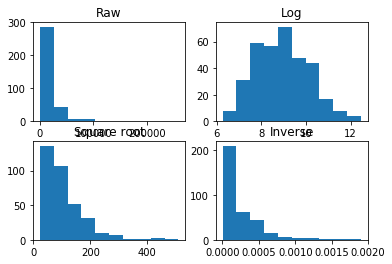

In [16]:
#check if log, square root or inverse are normally distributed
fig = plt.figure()

fig.add_subplot(221)
plt.hist(features['population'])
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(features['population']))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(features['population']))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/features['population'])
plt.title('Inverse')
plt.show()

The log of popluation appears to be approximately normally distributed, allowing us to use it to form a regression model.

In [17]:
#data to plot
x = pd.DataFrame(np.log(features['population']))
y = pd.DataFrame(features['property crime'])

Coefficients: 
 [[ 457.13488169]]
Intercept: 
 [-3710.96342301]


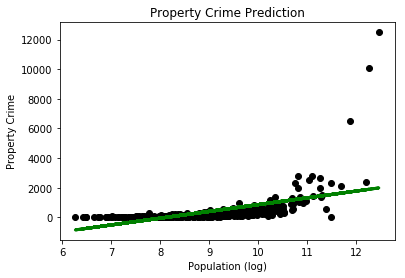

In [18]:
#instantiate model
regr = linear_model.LinearRegression()

#fit model to data
regr.fit(x, y)

# display calculated attributes
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

#create regression plot
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='green', linewidth=3)
plt.title('Property Crime Prediction')
plt.xlabel('Population (log)')
plt.ylabel('Property Crime')
plt.show()

There is a positive correlation between population and property crome rates. There are a few points that are far from the regression line, but it looks as though the regression model is generally accurate.